In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import keras.layers as KL
import utils
import visualize
from visualize import display_images
import model as modellib
from model import *

%matplotlib inline 

# Root directory of the project
root_dir = os.getcwd()

# Directory to save logs and trained model
model_dir = os.path.join(root_dir, "logs")

# Local path to trained weights file
dehaze_model_path = os.path.join(root_dir, "mask_rcnn_domain.h5")


In [3]:
from utils import*

In [4]:
from keras.engine import Layer
def reverse_gradient(X, hp_lambda):
    '''Flips the sign of the incoming gradient during training.'''
    try:
        reverse_gradient.num_calls += 1
    except AttributeError:
        reverse_gradient.num_calls = 1

    grad_name = "GradientReversal%d" % reverse_gradient.num_calls

    @tf.RegisterGradient(grad_name)
    def _flip_gradients(op, grad):
        return [tf.negative(grad) * hp_lambda]

    g = K.get_session().graph
    with g.gradient_override_map({'Identity': grad_name}):
        y = tf.identity(X)

    return y

class GradientReversal(Layer):
    '''Flip the sign of gradient during training.'''
    def __init__(self, hp_lambda, **kwargs):
        super(GradientReversal, self).__init__(**kwargs)
        self.supports_masking = False
        self.hp_lambda = hp_lambda

    def build(self, input_shape):
        self.trainable_weights = []

    def call(self, x, mask=None):
        return reverse_gradient(x, self.hp_lambda)

    def get_output_shape_for(self, input_shape):
        return input_shape

    def get_config(self):
        config = {'hp_lambda': self.hp_lambda}
        base_config = super(GradientReversal, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

from keras.layers import Input, Dense, Conv2D, Concatenate, Flatten
from keras.models import Model, Sequential

# This returns a tensor
inputs = Input(shape=(28,28,1))

# a layer instance is callable on a tensor, and returns a tensor
C1 = x = Conv2D(256, (2,2))(inputs)
C2 = x = Conv2D(128, (2,2))(x)
C1 = Conv2D(128, (1,1))(C1)
C2 = Conv2D(128, (1,1))(C2)
C1_before = Flatten()(C1)
C2 = Flatten()(C2)
Flip = GradientReversal(0.1)
C1_after = Flip(C1_before)
C1 = Dense(128, activation='relu')(C1_after)
C2 = Dense(128, activation='relu')(C2)

C3 = Concatenate()([C1, C2])

predictions = Dense(10, activation='softmax')(C3)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)

In [5]:
# MS COCO Dataset
import coco
config = coco.CocoConfig()
COCO_DIR = "COCO"  # TODO: enter value here
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    BATCH_SIZE=2

config = InferenceConfig()
# config.display()

In [6]:
config.BATCH_SIZE

1

In [7]:
def domain_loss_graph(domain_label, domain_logits):
    loss = K.categorical_crossentropy(domain_label, domain_logits)
    return loss

In [8]:
def get_image_by_id(img_idx, img_dir, img_names):
    image_name = img_names[img_idx]
    image = skimage.io.imread(os.path.join(img_dir, image_name))
    if image.shape[-1] == 4:
        image = image[:,:,0:3]
    image, window, scale, padding = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        max_dim=config.IMAGE_MAX_DIM,
        padding=config.IMAGE_PADDING)
    return image

In [9]:

def domain_data_generator(dataset, config, domain_image_dir, domain_image_names, shuffle=True, augment=True, random_rois=0,
                   batch_size=2, detection_targets=False):
    """A generator that returns images and corresponding target class ids,
    bounding box deltas, and masks.

    dataset: The Dataset object to pick data from
    config: The model config object
    shuffle: If True, shuffles the samples before every epoch
    augment: If True, applies image augmentation to images (currently only
             horizontal flips are supported)
    random_rois: If > 0 then generate proposals to be used to train the
                 network classifier and mask heads. Useful if training
                 the Mask RCNN part without the RPN.
    batch_size: How many images to return in each call
    detection_targets: If True, generate detection targets (class IDs, bbox
        deltas, and masks). Typically for debugging or visualizations because
        in trainig detection targets are generated by DetectionTargetLayer.

    Returns a Python generator. Upon calling next() on it, the
    generator returns two lists, inputs and outputs. The containtes
    of the lists differs depending on the received arguments:
    inputs list:
    - images: [batch, H, W, C]
    - image_meta: [batch, size of image meta]
    - rpn_match: [batch, N] Integer (1=positive anchor, -1=negative, 0=neutral)
    - rpn_bbox: [batch, N, (dy, dx, log(dh), log(dw))] Anchor bbox deltas.
    - gt_class_ids: [batch, MAX_GT_INSTANCES] Integer class IDs
    - gt_boxes: [batch, MAX_GT_INSTANCES, (y1, x1, y2, x2)]
    - gt_masks: [batch, height, width, MAX_GT_INSTANCES]. The height and width
                are those of the image unless use_mini_mask is True, in which
                case they are defined in MINI_MASK_SHAPE.
    - domain_class: [batch, y]

    outputs list: Usually empty in regular training. But if detection_targets
        is True then the outputs list contains target class_ids, bbox deltas,
        and masks.
    """
    b = 0  # batch item index
    image_index = -1
    image_ids = np.copy(dataset.image_ids)
    error_count = 0
    # Anchors
    # [anchor_count, (y1, x1, y2, x2)]
    anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES,
                                             config.RPN_ANCHOR_RATIOS,
                                             config.BACKBONE_SHAPES,
                                             config.BACKBONE_STRIDES,
                                             config.RPN_ANCHOR_STRIDE)

    # Keras requires a generator to run indefinately.
    while True:
        try:
            # Increment index to pick next image. Shuffle if at the start of an epoch.
            image_index = (image_index + 1) % len(image_ids)
            if shuffle and image_index == 0:
                np.random.shuffle(image_ids)
                np.random.shuffle(domain_image_names)
            
            # Get GT bounding boxes and masks for image.
            image_id = image_ids[image_index]
            image, image_meta, gt_class_ids, gt_boxes, gt_masks = \
                load_image_gt(dataset, config, image_id, augment=augment,
                              use_mini_mask=config.USE_MINI_MASK)

            
            # Get the dehaze image
            domain_image = get_image_by_id(image_index, domain_image_dir, domain_image_names)
            domain_image = mold_image(domain_image.astype(np.float32), config)
            
            # Skip images that have no instances. This can happen in cases
            # where we train on a subset of classes and the image doesn't
            # have any of the classes we care about.
            if not np.any(gt_class_ids > 0):
                continue

            # RPN Targets
            rpn_match, rpn_bbox = build_rpn_targets(image.shape, anchors,
                                                    gt_class_ids, gt_boxes, config)

            # Mask R-CNN Targets
            if random_rois:
                rpn_rois = generate_random_rois(
                    image.shape, random_rois, gt_class_ids, gt_boxes)
                if detection_targets:
                    rois, mrcnn_class_ids, mrcnn_bbox, mrcnn_mask =\
                        build_detection_targets(
                            rpn_rois, gt_class_ids, gt_boxes, gt_masks, config)
            # Init batch arrays
            if b == 0:
                batch_image_meta = np.zeros(
                    (batch_size,) + image_meta.shape, dtype=image_meta.dtype)
                batch_rpn_match = np.zeros(
                    [batch_size, anchors.shape[0], 1], dtype=rpn_match.dtype)
                batch_rpn_bbox = np.zeros(
                    [batch_size, config.RPN_TRAIN_ANCHORS_PER_IMAGE, 4], dtype=rpn_bbox.dtype)
                batch_images = np.zeros(
                    (batch_size,) + image.shape, dtype=np.float32)
                batch_gt_class_ids = np.zeros(
                    (batch_size, config.MAX_GT_INSTANCES), dtype=np.int32)
                batch_gt_boxes = np.zeros(
                    (batch_size, config.MAX_GT_INSTANCES, 4), dtype=np.int32)
                
                # add batch domain class label
                batch_domain_classes = np.zeros((batch_size, 2), dtype = np.float32)
                
                
                if config.USE_MINI_MASK:
                    batch_gt_masks = np.zeros((batch_size, config.MINI_MASK_SHAPE[0], config.MINI_MASK_SHAPE[1],
                                               config.MAX_GT_INSTANCES))
                else:
                    batch_gt_masks = np.zeros(
                        (batch_size, image.shape[0], image.shape[1], config.MAX_GT_INSTANCES))
                if random_rois:
                    batch_rpn_rois = np.zeros(
                        (batch_size, rpn_rois.shape[0], 4), dtype=rpn_rois.dtype)
                    if detection_targets:
                        batch_rois = np.zeros(
                            (batch_size,) + rois.shape, dtype=rois.dtype)
                        batch_mrcnn_class_ids = np.zeros(
                            (batch_size,) + mrcnn_class_ids.shape, dtype=mrcnn_class_ids.dtype)
                        batch_mrcnn_bbox = np.zeros(
                            (batch_size,) + mrcnn_bbox.shape, dtype=mrcnn_bbox.dtype)
                        batch_mrcnn_mask = np.zeros(
                            (batch_size,) + mrcnn_mask.shape, dtype=mrcnn_mask.dtype)

            # If more instances than fits in the array, sub-sample from them.
            if gt_boxes.shape[0] > config.MAX_GT_INSTANCES:
                ids = np.random.choice(
                    np.arange(gt_boxes.shape[0]), config.MAX_GT_INSTANCES, replace=False)
                gt_class_ids = gt_class_ids[ids]
                gt_boxes = gt_boxes[ids]
                gt_masks = gt_masks[:, :, ids]

            # Add to batch
            batch_image_meta[b] = image_meta
            batch_rpn_match[b] = rpn_match[:, np.newaxis]
            batch_rpn_bbox[b] = rpn_bbox
            batch_images[b] = mold_image(image.astype(np.float32), config)
            batch_gt_class_ids[b, :gt_class_ids.shape[0]] = gt_class_ids
            batch_gt_boxes[b, :gt_boxes.shape[0]] = gt_boxes
            batch_gt_masks[b, :, :, :gt_masks.shape[-1]] = gt_masks
            batch_domain_classes[b] = [1, 0]
            
            
            # Domain index
            d_index = batch_size/2 + b
            batch_images[d_index] = domain_image
            batch_domain_classes[d_index] = [0, 1]
            
            batch_image_meta[d_index] = image_meta
            batch_rpn_match[d_index] = rpn_match[:, np.newaxis]
            batch_rpn_bbox[d_index] = rpn_bbox
            batch_gt_class_ids[d_index, :gt_class_ids.shape[0]] = gt_class_ids
            batch_gt_boxes[d_index, :gt_boxes.shape[0]] = gt_boxes
            batch_gt_masks[d_index, :, :, :gt_masks.shape[-1]] = gt_masks


            if random_rois:
                batch_rpn_rois[b] = rpn_rois
                if detection_targets:
                    batch_rois[b] = rois
                    batch_mrcnn_class_ids[b] = mrcnn_class_ids
                    batch_mrcnn_bbox[b] = mrcnn_bbox
                    batch_mrcnn_mask[b] = mrcnn_mask
            b += 1

            # Batch full?
            if 2*b >= batch_size:
                inputs = [batch_images, batch_image_meta, batch_rpn_match, batch_rpn_bbox,
                          batch_gt_class_ids, batch_gt_boxes, batch_gt_masks, batch_domain_classes]
                outputs = []

                if random_rois:
                    inputs.extend([batch_rpn_rois])
                    if detection_targets:
                        inputs.extend([batch_rois])
                        # Keras requires that output and targets have the same number of dimensions
                        batch_mrcnn_class_ids = np.expand_dims(
                            batch_mrcnn_class_ids, -1)
                        outputs.extend(
                            [batch_mrcnn_class_ids, batch_mrcnn_bbox, batch_mrcnn_mask])

                yield inputs, outputs

                # start a new batch
                b = 0
        except (GeneratorExit, KeyboardInterrupt):
            raise
        except:
            # Log it and skip the image
            logging.exception("Error processing image {}".format(
                dataset.image_info[image_id]))
            error_count += 1
            if error_count > 5:
                raise

In [10]:
def parse_partial_image_meta_graph(meta):
    """Parses a tensor that contains image attributes to its components.
    See compose_image_meta() for more details.

    meta: [batch, meta length] where meta length depends on NUM_CLASSES
    """
    image_id = meta[0:1, 0]
    image_shape = meta[0:1, 1:4]
    window = meta[0:1, 4:8]   # (y1, x1, y2, x2) window of image in in pixels
    active_class_ids = meta[0:1, 8:]
    return [image_id, image_shape, window, active_class_ids]

In [11]:
# Get the first available GPU
DEVICE_ID_LIST = GPUtil.getFirstAvailable()
DEVICE_ID = DEVICE_ID_LIST[0] # grab first element from list

# Set CUDA_VISIBLE_DEVICES to mask out all other GPUs than the first available device id
os.environ["CUDA_VISIBLE_DEVICES"] = str(DEVICE_ID)

In [15]:

class Domain_MaskRCNN():
    """Encapsulates the Mask RCNN model functionality.

    The actual Keras model is in the keras_model property.
    """

    def __init__(self, mode, config, model_dir):
        """
        mode: Either "training" or "inference"
        config: A Sub-class of the Config class
        model_dir: Directory to save training logs and trained weights
        """
        assert mode in ['training', 'inference']
        self.mode = mode
        self.config = config
        self.model_dir = model_dir
        self.set_log_dir()
        self.keras_model = self.build(mode=mode, config=config)
        
                    

    def build(self, mode, config):
        def layer_slice(x):
            return x[0:1]
        """Build Mask R-CNN architecture.
            input_shape: The shape of the input image.
            mode: Either "training" or "inference". The inputs and
                outputs of the model differ accordingly.
        """


        # Since all other GPUs are masked out, the first available GPU will now be identified as GPU:0
        device = '/gpu:0'
        print('Device ID (masked): ' + str(0))

        # Creates a graph.
        with tf.device(device):

            assert mode in ['training', 'inference']

            # Image size must be dividable by 2 multiple times
            h, w = config.IMAGE_SHAPE[:2]
            if h / 2**6 != int(h / 2**6) or w / 2**6 != int(w / 2**6):
                raise Exception("Image size must be dividable by 2 at least 6 times "
                                "to avoid fractions when downscaling and upscaling."
                                "For example, use 256, 320, 384, 448, 512, ... etc. ")

            # Inputs
            input_image = KL.Input(
                shape=config.IMAGE_SHAPE.tolist(), name="input_image")
            ori_input_image_meta = KL.Input(shape=[None], name="input_image_meta")
            if mode == "training":
                
                input_image_meta = KL.Lambda(layer_slice, name='sliced_image_meta')(ori_input_image_meta)
                
                
                # RPN GT
                ori_input_rpn_match = KL.Input(
                    shape=[None, 1], name="input_rpn_match", dtype=tf.int32)
                input_rpn_match = KL.Lambda(layer_slice, name='sliced_rpn_match')(ori_input_rpn_match)
                
                ori_input_rpn_bbox = KL.Input(
                    shape=[None, 4], name="input_rpn_bbox", dtype=tf.float32)
                input_rpn_bbox = KL.Lambda(layer_slice, name='sliced_rpn_bbox')(ori_input_rpn_bbox)
                
                
                # Detection GT (class IDs, bounding boxes, and masks)
                # 1. GT Class IDs (zero padded)
                ori_input_gt_class_ids = KL.Input(
                    shape=[None], name="input_gt_class_ids", dtype=tf.int32)
                input_gt_class_ids = KL.Lambda(layer_slice, name='sliced_gt_class_ids')(ori_input_gt_class_ids)
                
                # 2. GT Boxes in pixels (zero padded)
                # [batch, MAX_GT_INSTANCES, (y1, x1, y2, x2)] in image coordinates
                ori_input_gt_boxes = KL.Input(
                    shape=[None, 4], name="input_gt_boxes", dtype=tf.float32)
                input_gt_boxes = KL.Lambda(layer_slice, name='sliced_gt_boxes')(ori_input_gt_boxes)
                
                # Normalize coordinates
                h, w = K.shape(input_image)[1], K.shape(input_image)[2]
                image_scale = K.cast(K.stack([h, w, h, w], axis=0), tf.float32)
                gt_boxes = KL.Lambda(lambda x: x / image_scale)(input_gt_boxes)
                # 3. GT Masks (zero padded)
                # [batch, height, width, MAX_GT_INSTANCES]
                if config.USE_MINI_MASK:
                    ori_input_gt_masks = KL.Input(
                        shape=[config.MINI_MASK_SHAPE[0],
                               config.MINI_MASK_SHAPE[1], None],
                        name="input_gt_masks", dtype=bool)
                else:
                    ori_input_gt_masks = KL.Input(
                        shape=[config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], None],
                        name="input_gt_masks", dtype=bool)
                
                input_gt_masks = KL.Lambda(layer_slice, name='sliced_gt_masks')(ori_input_gt_masks)
                
                
                # Domain class label
                input_domain_label = KL.Input(shape=[2], name = "input_domain_label", dtype = tf.float32)

            # Build the shared convolutional layers.
            # Bottom-up Layers
            # Returns a list of the last layers of each stage, 5 in total.
            # Don't create the thead (stage 5), so we pick the 4th item in the list.
            _, C2, C3, C4, C5 = resnet_graph(input_image, "resnet101", stage5=True)
            # Top-down Layers
            # TODO: add assert to varify feature map sizes match what's in config
            P5 = KL.Conv2D(256, (1, 1), name='fpn_c5p5')(C5)
            P4 = KL.Add(name="fpn_p4add")([
                KL.UpSampling2D(size=(2, 2), name="fpn_p5upsampled")(P5),
                KL.Conv2D(256, (1, 1), name='fpn_c4p4')(C4)])
            P3 = KL.Add(name="fpn_p3add")([
                KL.UpSampling2D(size=(2, 2), name="fpn_p4upsampled")(P4),
                KL.Conv2D(256, (1, 1), name='fpn_c3p3')(C3)])
            P2 = KL.Add(name="fpn_p2add")([
                KL.UpSampling2D(size=(2, 2), name="fpn_p3upsampled")(P3),
                KL.Conv2D(256, (1, 1), name='fpn_c2p2')(C2)])
            # Attach 3x3 conv to all P layers to get the final feature maps.
            P2 = KL.Conv2D(256, (3, 3), padding="SAME", name="fpn_p2")(P2)
            P3 = KL.Conv2D(256, (3, 3), padding="SAME", name="fpn_p3")(P3)
            P4 = KL.Conv2D(256, (3, 3), padding="SAME", name="fpn_p4")(P4)
            P5 = KL.Conv2D(256, (3, 3), padding="SAME", name="fpn_p5")(P5)
            # P6 is used for the 5th anchor scale in RPN. Generated by
            # subsampling from P5 with stride of 2.
            P6 = KL.MaxPooling2D(pool_size=(1, 1), strides=2, name="fpn_p6")(P5)

            # Note that P6 is used in RPN, but not in the classifier heads.
            
            
            # Domain classification model
            
            
            
            
            Flip = GradientReversal(0.1)
            
            F2 = Flip(P2)
            F3 = Flip(P3)
            F4 = Flip(P4)
            F5 = Flip(P5)
            
            # F2 is 256*256, it goes through 4 2*2 conv2D with maxpolling and 1 1*1 conv
            # F3 is 128*128, it goes through 3 2*2 conv2D with maxpolling and 2 1*1 conv
            # F4 is 64*64, it goes through 2 2*2 conv2D with maxpolling and 3 1*1 conv
            # F5 is 32*32, it goes through 1 2*2 conv2D with maxpolling and 4 1*1 conv
            
            
            # 1st layer
            F2 = KL.Conv2D(128, (2,2), padding="same", name="domain_0_2_2_conv_f2")(F2)
            F3 = KL.Conv2D(128, (1,1), padding="same", name="domain_0_1_1_conv_f3")(F3)
            F4 = KL.Conv2D(128, (1,1), padding="same", name="domain_0_1_1_conv_f4")(F4)
            F5 = KL.Conv2D(128, (1,1), padding="same", name="domain_0_1_1_conv_f5")(F5)
            
            F2 = KL.Activation('relu')(F2)
            F3 = KL.Activation('relu')(F3)
            F4 = KL.Activation('relu')(F4)
            F5 = KL.Activation('relu')(F5)
            
            
            F2 = KL.MaxPool2D((2,2), name="domain_0_2_2_max_f2")(F2)
            
            # 2nd layer
            F2 = KL.Conv2D(128, (2,2), padding="same", name="domain_1_2_2_conv_f2")(F2)
            F3 = KL.Conv2D(128, (2,2), padding="same", name="domain_1_2_2_conv_f3")(F3)
            F4 = KL.Conv2D(128, (1,1), padding="same", name="domain_1_1_1_conv_f4")(F4)
            F5 = KL.Conv2D(128, (1,1), padding="same", name="domain_1_1_1_conv_f5")(F5)
            
            F2 = KL.Activation('relu')(F2)
            F3 = KL.Activation('relu')(F3)
            F4 = KL.Activation('relu')(F4)
            F5 = KL.Activation('relu')(F5)
            
            F2 = KL.MaxPool2D((2,2), name="domain_1_2_2_max_f2")(F2)
            F3 = KL.MaxPool2D((2,2), name="domain_1_2_2_max_f3")(F3)
            
            # 3rd layer
            F2 = KL.Conv2D(128, (2,2), padding="same", name="domain_2_2_2_conv_f2")(F2)
            F3 = KL.Conv2D(128, (2,2), padding="same", name="domain_2_2_2_conv_f3")(F3)
            F4 = KL.Conv2D(128, (2,2), padding="same", name="domain_2_2_2_conv_f4")(F4)
            F5 = KL.Conv2D(128, (1,1), padding="same", name="domain_2_1_1_conv_f5")(F5)
            
            F2 = KL.Activation('relu')(F2)
            F3 = KL.Activation('relu')(F3)
            F4 = KL.Activation('relu')(F4)
            F5 = KL.Activation('relu')(F5)
            
            F2 = KL.MaxPool2D((2,2), name="domain_2_2_2_max_f2")(F2)
            F3 = KL.MaxPool2D((2,2), name="domain_2_2_2_max_f3")(F3)
            F4 = KL.MaxPool2D((2,2), name="domain_2_2_2_max_f4")(F4)
            
            # 4th layer
            F2 = KL.Conv2D(128, (2,2), padding="same", name="domain_3_2_2_conv_f2")(F2)
            F3 = KL.Conv2D(128, (2,2), padding="same", name="domain_3_2_2_conv_f3")(F3)
            F4 = KL.Conv2D(128, (2,2), padding="same", name="domain_3_2_2_conv_f4")(F4)
            F5 = KL.Conv2D(128, (2,2), padding="same", name="domain_3_2_2_conv_f5")(F5)
            
            F2 = KL.Activation('relu')(F2)
            F3 = KL.Activation('relu')(F3)
            F4 = KL.Activation('relu')(F4)
            F5 = KL.Activation('relu')(F5)
            
            F2 = KL.MaxPool2D((2,2), name="domain_3_2_2_max_f2")(F2)
            F3 = KL.MaxPool2D((2,2), name="domain_3_2_2_max_f3")(F3)
            F4 = KL.MaxPool2D((2,2), name="domain_3_2_2_max_f4")(F4)
            F5 = KL.MaxPool2D((2,2), name="domain_3_2_2_max_f5")(F5)
            
            
            # All 1*1 layer
            F2 = KL.Conv2D(128, (1,1), padding="same", name="domain_all_1_1_conv_f2")(F2)
            F3 = KL.Conv2D(128, (1,1), padding="same", name="domain_all_1_1_conv_f3")(F3)
            F4 = KL.Conv2D(128, (1,1), padding="same", name="domain_all_1_1_conv_f4")(F4)
            F5 = KL.Conv2D(128, (1,1), padding="same", name="domain_all_1_1_conv_f5")(F5)
            
            F2 = KL.Activation('relu')(F2)
            F3 = KL.Activation('relu')(F3)
            F4 = KL.Activation('relu')(F4)
            F5 = KL.Activation('relu')(F5)
            
            F2 = KL.Flatten()(F2)
            F3 = KL.Flatten()(F3)
            F4 = KL.Flatten()(F4)
            F5 = KL.Flatten()(F5)

            # Dense layer
            F2 = KL.Dense(128, activation='relu', name="domain_dense_f2")(F2)
            F3 = KL.Dense(128, activation='relu', name="domain_dense_f3")(F3)
            F4 = KL.Dense(128, activation='relu', name="domain_dense_f4")(F4)
            F5 = KL.Dense(128, activation='relu', name="domain_dense_f5")(F5)
            
            # Concatenate
            F_out = KL.Concatenate()([F2, F3, F4, F5])
            
            # Fully connected layer
            F_out = KL.Dense(512, activation='relu', name="domain_output_fc1")(F_out)
            F_out = KL.Dense(128, activation='relu', name="domain_output_fc2")(F_out)
            
            # Output Layer
            domain_class_logits = KL.Dense(2, activation='softmax', name="domain_output_logits")(F_out)
            
            
            
            # During the training, the batch size = 2, we need to split the feature map
            # so that the COCO data feature map goes into the maskrcnn part
            
            
            if mode == "training":

                P2 = KL.Lambda(layer_slice)(P2)
                P3 = KL.Lambda(layer_slice)(P3)
                P4 = KL.Lambda(layer_slice)(P4)
                P5 = KL.Lambda(layer_slice)(P5)
                P6 = KL.Lambda(layer_slice)(P6)

            
            
            
            rpn_feature_maps = [P2, P3, P4, P5, P6]
            mrcnn_feature_maps = [P2, P3, P4, P5]

            # Generate Anchors
            self.anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES,
                                                          config.RPN_ANCHOR_RATIOS,
                                                          config.BACKBONE_SHAPES,
                                                          config.BACKBONE_STRIDES,
                                                          config.RPN_ANCHOR_STRIDE)

            # RPN Model
            rpn = build_rpn_model(config.RPN_ANCHOR_STRIDE,
                                  len(config.RPN_ANCHOR_RATIOS), 256)
            # Loop through pyramid layers
            layer_outputs = []  # list of lists
            for p in rpn_feature_maps:
                layer_outputs.append(rpn([p]))
            # Concatenate layer outputs
            # Convert from list of lists of level outputs to list of lists
            # of outputs across levels.
            # e.g. [[a1, b1, c1], [a2, b2, c2]] => [[a1, a2], [b1, b2], [c1, c2]]
            output_names = ["rpn_class_logits", "rpn_class", "rpn_bbox"]
            outputs = list(zip(*layer_outputs))
            outputs = [KL.Concatenate(axis=1, name=n)(list(o))
                       for o, n in zip(outputs, output_names)]

            rpn_class_logits, rpn_class, rpn_bbox = outputs

            # Generate proposals
            # Proposals are [batch, N, (y1, x1, y2, x2)] in normalized coordinates
            # and zero padded.
            proposal_count = config.POST_NMS_ROIS_TRAINING if mode == "training"\
                else config.POST_NMS_ROIS_INFERENCE
            rpn_rois = ProposalLayer(proposal_count=proposal_count,
                                     nms_threshold=config.RPN_NMS_THRESHOLD,
                                     name="ROI",
                                     anchors=self.anchors,
                                     config=config)([rpn_class, rpn_bbox])
            
            
            if mode == "training":
                # Class ID mask to mark class IDs supported by the dataset the image
                # came from.
                
                # we only parse partial image meta here
                _, _, _, active_class_ids = KL.Lambda(lambda x: parse_image_meta_graph(x),
                                                      mask=[None, None, None, None])(input_image_meta)

                if not config.USE_RPN_ROIS:
                    # Ignore predicted ROIs and use ROIs provided as an input.
                    input_rois = KL.Input(shape=[config.POST_NMS_ROIS_TRAINING, 4],
                                          name="input_roi", dtype=np.int32)
                    # Normalize coordinates to 0-1 range.
                    target_rois = KL.Lambda(lambda x: K.cast(
                        x, tf.float32) / image_scale[:4])(input_rois)
                else:
                    target_rois = rpn_rois

                # Generate detection targets
                # Subsamples proposals and generates target outputs for training
                # Note that proposal class IDs, gt_boxes, and gt_masks are zero
                # padded. Equally, returned rois and targets are zero padded.
                rois, target_class_ids, target_bbox, target_mask =\
                    DetectionTargetLayer(config, name="proposal_targets")([
                        target_rois, input_gt_class_ids, gt_boxes, input_gt_masks])

                # Network Heads
                # TODO: verify that this handles zero padded ROIs
                mrcnn_class_logits, mrcnn_class, mrcnn_bbox =\
                    fpn_classifier_graph(rois, mrcnn_feature_maps, config.IMAGE_SHAPE,
                                         config.POOL_SIZE, config.NUM_CLASSES)

                mrcnn_mask = build_fpn_mask_graph(rois, mrcnn_feature_maps,
                                                  config.IMAGE_SHAPE,
                                                  config.MASK_POOL_SIZE,
                                                  config.NUM_CLASSES)

                # TODO: clean up (use tf.identify if necessary)
                output_rois = KL.Lambda(lambda x: x * 1, name="output_rois")(rois)

                # Losses
                rpn_class_loss = KL.Lambda(lambda x: rpn_class_loss_graph(*x), name="rpn_class_loss")(
                    [input_rpn_match, rpn_class_logits])
                rpn_bbox_loss = KL.Lambda(lambda x: rpn_bbox_loss_graph(config, *x), name="rpn_bbox_loss")(
                    [input_rpn_bbox, input_rpn_match, rpn_bbox])
                class_loss = KL.Lambda(lambda x: mrcnn_class_loss_graph(*x), name="mrcnn_class_loss")(
                    [target_class_ids, mrcnn_class_logits, active_class_ids])
                bbox_loss = KL.Lambda(lambda x: mrcnn_bbox_loss_graph(*x), name="mrcnn_bbox_loss")(
                    [target_bbox, target_class_ids, mrcnn_bbox])
                mask_loss = KL.Lambda(lambda x: mrcnn_mask_loss_graph(*x), name="mrcnn_mask_loss")(
                    [target_mask, target_class_ids, mrcnn_mask])
                
                #domain classification loss
                domain_loss = KL.Lambda(lambda x: domain_loss_graph(*x), name="domain_classification_loss")(
                    [input_domain_label, domain_class_logits])

                # Model
                inputs = [input_image, ori_input_image_meta,
                          ori_input_rpn_match, ori_input_rpn_bbox, ori_input_gt_class_ids, 
                          ori_input_gt_boxes, ori_input_gt_masks, input_domain_label]
                if not config.USE_RPN_ROIS:
                    inputs.append(inputa_rois)
                outputs = [rpn_class_logits, rpn_class, rpn_bbox,
                           mrcnn_class_logits, mrcnn_class, mrcnn_bbox, mrcnn_mask,
                           rpn_rois, output_rois,
                           rpn_class_loss, rpn_bbox_loss, class_loss, bbox_loss, mask_loss, domain_loss]
                model = KM.Model(inputs, outputs, name='mask_rcnn')
            else:
                # Network Heads
                # Proposal classifier and BBox regressor heads
                mrcnn_class_logits, mrcnn_class, mrcnn_bbox =\
                    fpn_classifier_graph(rpn_rois, mrcnn_feature_maps, config.IMAGE_SHAPE,
                                         config.POOL_SIZE, config.NUM_CLASSES)

                # Detections
                # output is [batch, num_detections, (y1, x1, y2, x2, class_id, score)] in image coordinates
                detections = DetectionLayer(config, name="mrcnn_detection")(
                    [rpn_rois, mrcnn_class, mrcnn_bbox, ori_input_image_meta])

                # Convert boxes to normalized coordinates
                # TODO: let DetectionLayer return normalized coordinates to avoid
                #       unnecessary conversions
                h, w = config.IMAGE_SHAPE[:2]
                detection_boxes = KL.Lambda(
                    lambda x: x[..., :4] / np.array([h, w, h, w]))(detections)

                # Create masks for detections
                mrcnn_mask = build_fpn_mask_graph(detection_boxes, mrcnn_feature_maps,
                                                  config.IMAGE_SHAPE,
                                                  config.MASK_POOL_SIZE,
                                                  config.NUM_CLASSES)

                model = KM.Model([input_image, ori_input_image_meta],
                                 [detections, mrcnn_class, mrcnn_bbox,
                                     mrcnn_mask, rpn_rois, rpn_class, rpn_bbox],
                                 name='mask_rcnn')

            # Add multi-GPU support.
            if config.GPU_COUNT > 1:
                from parallel_model import ParallelModel
                model = ParallelModel(model, config.GPU_COUNT)

        return model

    def find_last(self):
        """Finds the last checkpoint file of the last trained model in the
        model directory.
        Returns:
            log_dir: The directory where events and weights are saved
            checkpoint_path: the path to the last checkpoint file
        """
        # Get directory names. Each directory corresponds to a model
        dir_names = next(os.walk(self.model_dir))[1]
        key = self.config.NAME.lower()
        dir_names = filter(lambda f: f.startswith(key), dir_names)
        dir_names = sorted(dir_names)
        if not dir_names:
            return None, None
        # Pick last directory
        dir_name = os.path.join(self.model_dir, dir_names[-1])
        # Find the last checkpoint
        checkpoints = next(os.walk(dir_name))[2]
        checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
        checkpoints = sorted(checkpoints)
        if not checkpoints:
            return dir_name, None
        checkpoint = os.path.join(dir_name, checkpoints[-1])
        return dir_name, checkpoint

    def load_weights(self, filepath, by_name=False, exclude=None):
        """Modified version of the correspoding Keras function with
        the addition of multi-GPU support and the ability to exclude
        some layers from loading.
        exlude: list of layer names to excluce
        """
        import h5py
        from keras.engine import topology

        if exclude:
            by_name = True

        if h5py is None:
            raise ImportError('`load_weights` requires h5py.')
        f = h5py.File(filepath, mode='r')
        if 'layer_names' not in f.attrs and 'model_weights' in f:
            f = f['model_weights']

        # In multi-GPU training, we wrap the model. Get layers
        # of the inner model because they have the weights.
        keras_model = self.keras_model
        layers = keras_model.inner_model.layers if hasattr(keras_model, "inner_model")\
            else keras_model.layers

        # Exclude some layers
        if exclude:
            layers = filter(lambda l: l.name not in exclude, layers)

        if by_name:
            topology.load_weights_from_hdf5_group_by_name(f, layers)
        else:
            topology.load_weights_from_hdf5_group(f, layers)
        if hasattr(f, 'close'):
            f.close()

        # Update the log directory
        self.set_log_dir(filepath)

    def get_imagenet_weights(self):
        """Downloads ImageNet trained weights from Keras.
        Returns path to weights file.
        """
        from keras.utils.data_utils import get_file
        TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/'\
                                 'releases/download/v0.2/'\
                                 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
        weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                TF_WEIGHTS_PATH_NO_TOP,
                                cache_subdir='models',
                                md5_hash='a268eb855778b3df3c7506639542a6af')
        return weights_path

    def compile(self, learning_rate, momentum):
        """Gets the model ready for training. Adds losses, regularization, and
        metrics. Then calls the Keras compile() function.
        """
        # Optimizer object
        optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=momentum,
                                         clipnorm=5.0)
        # Add Losses
        # First, clear previously set losses to avoid duplication
        self.keras_model._losses = []
        self.keras_model._per_input_losses = {}
        loss_names = ["rpn_class_loss", "rpn_bbox_loss",
                      "mrcnn_class_loss", "mrcnn_bbox_loss", "mrcnn_mask_loss", "domain_classification_loss"]
        for name in loss_names:
            layer = self.keras_model.get_layer(name)
            if layer.output in self.keras_model.losses:
                continue
            self.keras_model.add_loss(
                tf.reduce_mean(layer.output, keep_dims=True))

        # Add L2 Regularization
        # Skip gamma and beta weights of batch normalization layers.
        reg_losses = [keras.regularizers.l2(self.config.WEIGHT_DECAY)(w) / tf.cast(tf.size(w), tf.float32)
                      for w in self.keras_model.trainable_weights
                      if 'gamma' not in w.name and 'beta' not in w.name]
        self.keras_model.add_loss(tf.add_n(reg_losses))

        # Compile
        self.keras_model.compile(optimizer=optimizer, loss=[
                                 None] * len(self.keras_model.outputs))

        # Add metrics for losses
        for name in loss_names:
            if name in self.keras_model.metrics_names:
                continue
            layer = self.keras_model.get_layer(name)
            self.keras_model.metrics_names.append(name)
            self.keras_model.metrics_tensors.append(tf.reduce_mean(
                layer.output, keep_dims=True))

    def set_trainable(self, layer_regex, keras_model=None, indent=0, verbose=1):
        """Sets model layers as trainable if their names match
        the given regular expression.
        """
        # Print message on the first call (but not on recursive calls)
        if verbose > 0 and keras_model is None:
            log("Selecting layers to train")

        keras_model = keras_model or self.keras_model

        # In multi-GPU training, we wrap the model. Get layers
        # of the inner model because they have the weights.
        layers = keras_model.inner_model.layers if hasattr(keras_model, "inner_model")\
            else keras_model.layers

        for layer in layers:
            # Is the layer a model?
            if layer.__class__.__name__ == 'Model':
                print("In model: ", layer.name)
                self.set_trainable(
                    layer_regex, keras_model=layer, indent=indent + 4)
                continue

            if not layer.weights:
                continue
            # Is it trainable?

            def fullmatch(regex, string, flags=0):
                """Emulate python-3.4 re.fullmatch()."""
                return re.match("(?:" + regex + r")\Z", string, flags=flags)

            trainable = bool(fullmatch(layer_regex, layer.name))
            # Update layer. If layer is a container, update inner layer.
            if layer.__class__.__name__ == 'TimeDistributed':
                layer.layer.trainable = trainable
            else:
                layer.trainable = trainable
            # Print trainble layer names
            if trainable and verbose > 0:
                log("{}{:20}   ({})".format(" " * indent, layer.name,
                                            layer.__class__.__name__))

    def set_log_dir(self, model_path=None):
        """Sets the model log directory and epoch counter.

        model_path: If None, or a format different from what this code uses
            then set a new log directory and start epochs from 0. Otherwise,
            extract the log directory and the epoch counter from the file
            name.
        """
        # Set date and epoch counter as if starting a new model
        self.epoch = 0
        now = datetime.datetime.now()

        # If we have a model path with date and epochs use them
        if model_path:
            # Continue from we left of. Get epoch and date from the file name
            # A sample model path might look like:
            # /path/to/logs/coco20171029T2315/mask_rcnn_coco_0001.h5
            regex = r".*/\w+(\d{4})(\d{2})(\d{2})T(\d{2})(\d{2})/mask\_rcnn\_\w+(\d{4})\.h5"
            m = re.match(regex, model_path)
            if m:
                now = datetime.datetime(int(m.group(1)), int(m.group(2)), int(m.group(3)),
                                        int(m.group(4)), int(m.group(5)))
                self.epoch = int(m.group(6)) + 1

        # Directory for training logs
        self.log_dir = os.path.join(self.model_dir, "{}{:%Y%m%dT%H%M}".format(
            self.config.NAME.lower(), now))

        # Path to save after each epoch. Include placeholders that get filled by Keras.
        self.checkpoint_path = os.path.join(self.log_dir, "mask_rcnn_{}_*epoch*.h5".format(
            self.config.NAME.lower()))
        self.checkpoint_path = self.checkpoint_path.replace(
            "*epoch*", "{epoch:04d}")

    def train(self, train_dataset, val_dataset, domain_image_dir, domain_image_names, learning_rate, epochs, layers):
        """Train the model.
        train_dataset, val_dataset: Training and validation Dataset objects.
        learning_rate: The learning rate to train with
        epochs: Number of training epochs. Note that previous training epochs
                are considered to be done alreay, so this actually determines
                the epochs to train in total rather than in this particaular
                call.
        layers: Allows selecting wich layers to train. It can be:
            - A regular expression to match layer names to train
            - One of these predefined values:
              heaads: The RPN, classifier and mask heads of the network
              all: All the layers
              3+: Train Resnet stage 3 and up
              4+: Train Resnet stage 4 and up
              5+: Train Resnet stage 5 and up
        """
        assert self.mode == "training", "Create model in training mode."

        # Pre-defined layer regular expressions
        layer_regex = {
            # all layers but the backbone
            "heads": r"(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            # From a specific Resnet stage and up
            "3+": r"(res3.*)|(bn3.*)|(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            "4+": r"(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            "5+": r"(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            # classification layers
            "domain": r"(domain\_.*)",
            # All layers
            "all": ".*",
        }
        if layers in layer_regex.keys():
            layers = layer_regex[layers]
        
        # Data generators
        train_generator = domain_data_generator(train_dataset, self.config,  domain_image_dir, domain_image_names, shuffle=True,
                                         batch_size=2)
        # Callbacks
        callbacks = [
            keras.callbacks.TensorBoard(log_dir=self.log_dir,
                                        histogram_freq=0, write_graph=True, write_images=False),
            keras.callbacks.ModelCheckpoint(self.checkpoint_path,
                                            verbose=0, save_weights_only=True),
        ]

        # Train
        log("\nStarting at epoch {}. LR={}\n".format(self.epoch, learning_rate))
        log("Checkpoint Path: {}".format(self.checkpoint_path))
        self.set_trainable(layers)
        self.compile(learning_rate, self.config.LEARNING_MOMENTUM)

        # Work-around for Windows: Keras fails on Windows when using
        # multiprocessing workers. See discussion here:
        # https://github.com/matterport/Mask_RCNN/issues/13#issuecomment-353124009
        if os.name is 'nt':
            workers = 0
        else:
            workers = max(self.config.BATCH_SIZE // 2, 2)

        self.keras_model.fit_generator(
            train_generator,
            initial_epoch=self.epoch,
            epochs=epochs,
            steps_per_epoch=self.config.STEPS_PER_EPOCH,
            callbacks=callbacks,
            max_queue_size=100,
            workers=workers,
            use_multiprocessing=True,
        )
        self.epoch = max(self.epoch, epochs)

    def mold_inputs(self, images):
        """Takes a list of images and modifies them to the format expected
        as an input to the neural network.
        images: List of image matricies [height,width,depth]. Images can have
            different sizes.

        Returns 3 Numpy matricies:
        molded_images: [N, h, w, 3]. Images resized and normalized.
        image_metas: [N, length of meta data]. Details about each image.
        windows: [N, (y1, x1, y2, x2)]. The portion of the image that has the
            original image (padding excluded).
        """
        molded_images = []
        image_metas = []
        windows = []
        for image in images:
            # Resize image to fit the model expected size
            # TODO: move resizing to mold_image()
            molded_image, window, scale, padding = utils.resize_image(
                image,
                min_dim=self.config.IMAGE_MIN_DIM,
                max_dim=self.config.IMAGE_MAX_DIM,
                padding=self.config.IMAGE_PADDING)
            molded_image = mold_image(molded_image, self.config)
            # Build image_meta
            image_meta = compose_image_meta(
                0, image.shape, window,
                np.zeros([self.config.NUM_CLASSES], dtype=np.int32))
            # Append
            molded_images.append(molded_image)
            windows.append(window)
            image_metas.append(image_meta)
        # Pack into arrays
        molded_images = np.stack(molded_images)
        image_metas = np.stack(image_metas)
        windows = np.stack(windows)
        return molded_images, image_metas, windows

    def unmold_detections(self, detections, mrcnn_mask, image_shape, window):
        """Reformats the detections of one image from the format of the neural
        network output to a format suitable for use in the rest of the
        application.

        detections: [N, (y1, x1, y2, x2, class_id, score)]
        mrcnn_mask: [N, height, width, num_classes]
        image_shape: [height, width, depth] Original size of the image before resizing
        window: [y1, x1, y2, x2] Box in the image where the real image is
                excluding the padding.

        Returns:
        boxes: [N, (y1, x1, y2, x2)] Bounding boxes in pixels
        class_ids: [N] Integer class IDs for each bounding box
        scores: [N] Float probability scores of the class_id
        masks: [height, width, num_instances] Instance masks
        """
        # How many detections do we have?
        # Detections array is padded with zeros. Find the first class_id == 0.
        zero_ix = np.where(detections[:, 4] == 0)[0]
        N = zero_ix[0] if zero_ix.shape[0] > 0 else detections.shape[0]

        # Extract boxes, class_ids, scores, and class-specific masks
        boxes = detections[:N, :4]
        class_ids = detections[:N, 4].astype(np.int32)
        scores = detections[:N, 5]
        masks = mrcnn_mask[np.arange(N), :, :, class_ids]

        # Compute scale and shift to translate coordinates to image domain.
        h_scale = image_shape[0] / (window[2] - window[0])
        w_scale = image_shape[1] / (window[3] - window[1])
        scale = min(h_scale, w_scale)
        shift = window[:2]  # y, x
        scales = np.array([scale, scale, scale, scale])
        shifts = np.array([shift[0], shift[1], shift[0], shift[1]])

        # Translate bounding boxes to image domain
        boxes = np.multiply(boxes - shifts, scales).astype(np.int32)

        # Filter out detections with zero area. Often only happens in early
        # stages of training when the network weights are still a bit random.
        exclude_ix = np.where(
            (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]) <= 0)[0]
        if exclude_ix.shape[0] > 0:
            boxes = np.delete(boxes, exclude_ix, axis=0)
            class_ids = np.delete(class_ids, exclude_ix, axis=0)
            scores = np.delete(scores, exclude_ix, axis=0)
            masks = np.delete(masks, exclude_ix, axis=0)
            N = class_ids.shape[0]

        # Resize masks to original image size and set boundary threshold.
        full_masks = []
        for i in range(N):
            # Convert neural network mask to full size mask
            full_mask = utils.unmold_mask(masks[i], boxes[i], image_shape)
            full_masks.append(full_mask)
        full_masks = np.stack(full_masks, axis=-1)\
            if full_masks else np.empty((0,) + masks.shape[1:3])

        return boxes, class_ids, scores, full_masks

    def detect(self, images, verbose=0):
        """Runs the detection pipeline.

        images: List of images, potentially of different sizes.

        Returns a list of dicts, one dict per image. The dict contains:
        rois: [N, (y1, x1, y2, x2)] detection bounding boxes
        class_ids: [N] int class IDs
        scores: [N] float probability scores for the class IDs
        masks: [H, W, N] instance binary masks
        """
        assert self.mode == "inference", "Create model in inference mode."
        assert len(
            images) == self.config.BATCH_SIZE, "len(images) must be equal to BATCH_SIZE"

        if verbose:
            log("Processing {} images".format(len(images)))
            for image in images:
                log("image", image)
        # Mold inputs to format expected by the neural network
        molded_images, image_metas, windows = self.mold_inputs(images)
        if verbose:
            log("molded_images", molded_images)
            log("image_metas", image_metas)
        # Run object detection
        detections, mrcnn_class, mrcnn_bbox, mrcnn_mask, \
            rois, rpn_class, rpn_bbox =\
            self.keras_model.predict([molded_images, image_metas], verbose=0)
        # Process detections
        results = []
        for i, image in enumerate(images):
            final_rois, final_class_ids, final_scores, final_masks =\
                self.unmold_detections(detections[i], mrcnn_mask[i],
                                       image.shape, windows[i])
            results.append({
                "rois": final_rois,
                "class_ids": final_class_ids,
                "scores": final_scores,
                "masks": final_masks,
            })
        return results

    def ancestor(self, tensor, name, checked=None):
        """Finds the ancestor of a TF tensor in the computation graph.
        tensor: TensorFlow symbolic tensor.
        name: Name of ancestor tensor to find
        checked: For internal use. A list of tensors that were already
                 searched to avoid loops in traversing the graph.
        """
        checked = checked if checked is not None else []
        # Put a limit on how deep we go to avoid very long loops
        if len(checked) > 500:
            return None
        # Convert name to a regex and allow matching a number prefix
        # because Keras adds them automatically
        if isinstance(name, str):
            name = re.compile(name.replace("/", r"(\_\d+)*/"))

        parents = tensor.op.inputs
        for p in parents:
            if p in checked:
                continue
            if bool(re.fullmatch(name, p.name)):
                return p
            checked.append(p)
            a = self.ancestor(p, name, checked)
            if a is not None:
                return a
        return None

    def find_trainable_layer(self, layer):
        """If a layer is encapsulated by another layer, this function
        digs through the encapsulation and returns the layer that holds
        the weights.
        """
        if layer.__class__.__name__ == 'TimeDistributed':
            return self.find_trainable_layer(layer.layer)
        return layer

    def get_trainable_layers(self):
        """Returns a list of layers that have weights."""
        layers = []
        # Loop through all layers
        for l in self.keras_model.layers:
            # If layer is a wrapper, find inner trainable layer
            l = self.find_trainable_layer(l)
            # Include layer if it has weights
            if l.get_weights():
                layers.append(l)
        return layers

    def run_graph(self, images, outputs):
        """Runs a sub-set of the computation graph that computes the given
        outputs.

        outputs: List of tuples (name, tensor) to compute. The tensors are
            symbolic TensorFlow tensors and the names are for easy tracking.

        Returns an ordered dict of results. Keys are the names received in the
        input and values are Numpy arrays.
        """
        model = self.keras_model

        # Organize desired outputs into an ordered dict
        outputs = OrderedDict(outputs)
        for o in outputs.values():
            assert o is not None

        # Build a Keras function to run parts of the computation graph
        inputs = model.inputs
        if model.uses_learning_phase and not isinstance(K.learning_phase(), int):
            inputs += [K.learning_phase()]
        kf = K.function(model.inputs, list(outputs.values()))

        # Run inference
        molded_images, image_metas, windows = self.mold_inputs(images)
        # TODO: support training mode?
        # if TEST_MODE == "training":
        #     model_in = [molded_images, image_metas,
        #                 target_rpn_match, target_rpn_bbox,
        #                 gt_boxes, gt_masks]
        #     if not config.USE_RPN_ROIS:
        #         model_in.append(target_rois)
        #     if model.uses_learning_phase and not isinstance(K.learning_phase(), int):
        #         model_in.append(1.)
        #     outputs_np = kf(model_in)
        # else:

        model_in = [molded_images, image_metas]
        if model.uses_learning_phase and not isinstance(K.learning_phase(), int):
            model_in.append(0.)
        outputs_np = kf(model_in)

        # Pack the generated Numpy arrays into a a dict and log the results.
        outputs_np = OrderedDict([(k, v)
                                  for k, v in zip(outputs.keys(), outputs_np)])
        for k, v in outputs_np.items():
            log(k, v)
        return outputs_np



In [26]:
domain_model = Domain_MaskRCNN(mode="training", model_dir=model_dir,
                          config=config)

Device ID (masked): 0


In [13]:
domain_model.keras_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_image (InputLayer)         (None, 1024, 1024, 3) 0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 1030, 1030, 3) 0           input_image[0][0]                
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 512, 512, 64)  9472        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNorm)             (None, 512, 512, 64)  256         conv1[0][0]                      
___________________________________________________________________________________________

In [13]:
root_dir = os.getcwd()
domain_image_dir = os.path.join(os.getcwd(), "HazeTrain")
domain_image_names = next(os.walk(domain_image_dir))[2]
domain_image_names.sort()

In [18]:
l = len(domain_image_names)

In [ ]:
img_idx, img_dir, img_names

In [20]:
x = get_image_by_id(1, domain_image_dir, domain_image_names)

/usr/lib/python2.7/dist-packages/scipy/misc/pilutil.py:479: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/lib/python2.7/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


In [22]:
x.shape == (1024, 1024, 3)

True

In [39]:
x = get_image_by_id(28, domain_image_dir, domain_image_names)

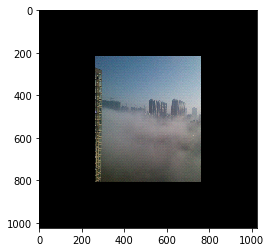

In [44]:
plt.imshow(x[:,:,0:3])
plt.show()

In [43]:
x[:,:,0:2].shape

(1024, 1024, 2)

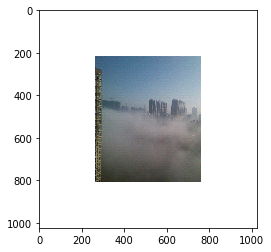

In [41]:
plt.imshow(x)
plt.show()

In [35]:
np.mean(x[:,:,3])

71.49696350097656

In [47]:
x.shape[-1]

4

In [26]:
domain_image_names[28]

'BD_Baidu_064.png'

In [29]:
im = skimage.io.imread(os.path.join(domain_image_dir, domain_image_names[28]))

In [30]:
im.shape

(588, 500, 4)

In [14]:
# Training dataset. Use the training set and 35K from the
# validation set, as as in the Mask RCNN paper.
year = 2014
dataset_train = coco.CocoDataset()
dataset_train.load_coco(COCO_DIR, "train", year=year, auto_download=True)
dataset_train.load_coco(COCO_DIR, "valminusminival", year=year, auto_download=True)
dataset_train.prepare()

# Validation dataset
dataset_val = coco.CocoDataset()
dataset_val.load_coco(COCO_DIR, "minival", year=year, auto_download=True)
dataset_val.prepare()

Will use images in COCO/train2014
Will use annotations in COCO/annotations/instances_train2014.json
loading annotations into memory...
Done (t=14.86s)
creating index...
index created!
Will use images in COCO/val2014
Will use annotations in COCO/annotations/instances_valminusminival2014.json
loading annotations into memory...
Done (t=7.76s)
creating index...
index created!
Will use images in COCO/val2014
Will use annotations in COCO/annotations/instances_minival2014.json
loading annotations into memory...
Done (t=0.62s)
creating index...
index created!


In [19]:
test_model = domain_model.keras_model

In [29]:
# Or load the last model you trained
# weights_path = model.find_last()[1]
# Load weights
print("Loading weights ", dehaze_model_path)
domain_model.load_weights(dehaze_model_path, by_name=True)

('Loading weights ', '/home/boyuan/Course_project/CSCE633/project/Mask_RCNN/mask_rcnn_domain.h5')


In [30]:
domain_model.keras_model.get_layer('domain_2_2_2_conv_f2').get_weights()

[array([[[[ 0.05132019,  0.05474571,  0.00521704, ...,  0.05630306,
           -0.03641768,  0.01793456],
          [ 0.00110844, -0.06778964,  0.02186352, ...,  0.0677876 ,
           -0.00132439, -0.0612884 ],
          [ 0.03141931, -0.07124393,  0.02933995, ...,  0.00188993,
            0.02403351, -0.06156543],
          ...,
          [-0.02822889,  0.07190148,  0.00094861, ...,  0.0669722 ,
           -0.02572981,  0.04694603],
          [ 0.05636757,  0.02675749,  0.06260365, ...,  0.06532735,
           -0.01837663, -0.06455874],
          [-0.07614732, -0.06048941,  0.03576919, ..., -0.03532176,
            0.01658802, -0.03855395]],
 
         [[-0.0073779 ,  0.07116687,  0.04448177, ..., -0.00837007,
            0.01424688,  0.04005597],
          [ 0.06177517,  0.01403334, -0.00812761, ..., -0.03209098,
            0.04197592,  0.02150483],
          [-0.05498389,  0.00754838,  0.03439912, ...,  0.06538413,
           -0.03121017,  0.05435117],
          ...,
          [ 0

In [17]:
# Training - Stage 1
print("Training domain classification model")
domain_model.train(dataset_train, dataset_val,  domain_image_dir, domain_image_names,
            learning_rate=config.LEARNING_RATE,
            epochs=1,
            layers='all')

Training domain classification model

Starting at epoch 0. LR=0.001

Checkpoint Path: /home/boyuan/Course_project/CSCE633/project/Mask_RCNN/logs/coco20180427T1932/mask_rcnn_coco_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2

/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python2.7/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
/usr/lib/python2.7/dist-packages/scipy/misc/pilutil.py:479: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/lib/python2.7/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is d

Epoch 1/1


/usr/lib/python2.7/dist-packages/scipy/ndimage/interpolation.py:552: RuntimeWarning: invalid value encountered in true_divide
  zoom = (numpy.array(input.shape) - 1) / zoom_div
/usr/lib/python2.7/dist-packages/scipy/ndimage/interpolation.py:549: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/usr/lib/python2.7/dist-packages/scipy/ndimage/interpolation.py:552: RuntimeWarning: invalid value encountered in true_divide
  zoom = (numpy.array(input.shape) - 1) / zoom_div


1000/1000 [==============================] - 861s - loss: 1.3800 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.2695 - mrcnn_class_loss: 0.2565 - mrcnn_bbox_loss: 0.1839 - mrcnn_mask_loss: 0.2660 - domain_classification_loss: 0.3876   


In [52]:
config.USE_MINI_MASK

True

In [18]:
save_dehaze_model_path = os.path.join(root_dir, "test_mask_rcnn_dehazing.h5")

In [19]:
domain_model.keras_model.save_weights(save_dehaze_model_path )

In [25]:
del domain_model
K.clear_session()